<a href="https://colab.research.google.com/github/talhaanwarch/Schizophrenia16/blob/master/classification_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!pip install wfdb
!pip install mne


In [3]:

!pip install git+https://github.com/forrestbao/pyeeg.git
!pip install git+https://github.com/talhaanwarch/entropy.git


  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-h802qi_1
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-h802qi_1
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28121 sha256=016d2537c4857663abe0b8b3c3ac068661671e82f7cd1c1c6ede6d9cb2ba4e13
  Stored in directory: /tmp/pip-ephem-wheel-cache-92bigv4_/wheels/2d/3f/ad/106d4fc80b61d1ea1fc18e76e7439fd98aa043d83d58eae741
Successfully built pyeeg
  Cloning https://github.com/talhaanwarch/entropy.git to /tmp/pip-req-build-ngq_cb4o
  Running command git clone -q https://github.com/talhaanwarch/entropy.git /tmp/pip-req-build-ngq_cb4o
  Created wheel for entropy: filename=entropy-0.1.1-cp36-none-any.whl size=15447 sha256=61d114df4cd65dc3f3c9c1cb43d777d597e219fab0f28bfaf4a80cd31cf0b0c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-uvlc6qqs/wheels/79/43/63/3fa9c8c5f03fe3a78d71c1aeedca9577f2f32fb2156ff9ecf8
Successfully built entropy


In [4]:
cd /content/drive/My Drive/dataset/schizophrenia16

/content/drive/My Drive/dataset/schizophrenia16


In [0]:
import numpy as np
from glob import glob

In [0]:
import pickle
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [0]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import signal


# Read Data

In [8]:
import numpy as np
x=np.array([1,2,3,4,5,6,7,8,9,10])
#first 5 represent one columns, next 5 represent next column
y=x.reshape(-1,5)
print(x)
print(y)
#http://brain.bio.msu.ru/eeg_schizophrenia.htm

[ 1  2  3  4  5  6  7  8  9 10]
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]]


In [0]:
HC_path=glob('norm/*.eea')
SZ_path=glob('sch/*.eea')

In [0]:
from scipy import signal
nyq = 0.5 * 128
l=0.1
low = l / nyq
high =60 / nyq
b, a = signal.butter(4, [low,high], 'band')
ch=16
pca=PCA(ch)

In [11]:
HC=[]#trialxsample x channels
for i in HC_path:
    data=np.loadtxt(i)
    data=data.reshape(-1,7680) #datapoints x columns
    print(data.shape)    
    data=signal.filtfilt(b, a, data) 
    print(data.shape) 
    data=pca.fit_transform(data.T)
    print(data.shape) 
    data=data.reshape(-1,512,ch)
    print(data.shape) 
    # data=np.swapaxes(data,0,1)
    # HC.append(data)
    break
# (122880,)
# (16, 7680)
# (16, 7680)
# (512, 15, 16)
# (15, 512, 16)

(16, 7680)
(16, 7680)
(7680, 16)
(15, 512, 16)


In [0]:
HC=[]#trialxsample x channels
for i in HC_path:
    data=np.loadtxt(i)
    data=data.reshape(-1,7680) #datapoints x columns
    data=signal.filtfilt(b, a, data) 
    data=pca.fit_transform(data.T)
    data=data.reshape(-1,512,ch)
    HC.append(data)


In [0]:
SZ=[]
for i in SZ_path:
    data=np.loadtxt(i)
    data=data.reshape(-1,7680) #datapoints x columns
    data=signal.filtfilt(b, a, data)
    data=pca.fit_transform(data.T)
    data=data.reshape(-1,512,ch)
    SZ.append(data)

In [14]:
data.shape

(15, 512, 16)

In [15]:
HC[0].shape,SZ[0].shape

((15, 512, 16), (15, 512, 16))

# Feature Calculation

In [0]:
from scipy import stats
import pyeeg
from entropy import *
def mean(data):
    return np.mean(data,axis=0)
    
def std(data):
    return np.std(data,axis=0)

def ptp(data):
    return np.ptp(data,axis=0)

def var(data):
        return np.var(data,axis=0)

def minim(data):
      return np.min(data,axis=0)


def maxim(data):
      return np.max(data,axis=0)


def mean_square(data):
      return np.mean(data**2,axis=0)

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=0))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)


def skewness(data):
    return stats.skew(data,axis=0)

def kurtosis(data):
    return stats.kurtosis(data,axis=0)

def zero_crossing(data):
    return np.argmax(np.diff(np.sign(data),axis=0),axis=0)

def app_epy(data):
    result=[]
    for i in data.T:
        result.append(app_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)

def perm_epy(data):
    result=[]
    for i in data.T:
        result.append(perm_entropy(i, order=3, normalize=True))
    return np.array(result)

def svd_epy(data):
    result=[]
    for i in data.T:
        result.append(svd_entropy(i, order=3, delay=1, normalize=True))
    return np.array(result)

def spectral_epy(data):
    result=[]
    for i in data.T:
        result.append(spectral_entropy(i, 100, method='welch', normalize=True))
    return np.array(result)

def sample_epy(data):
    result=[]
    for i in data.T:
        result.append(sample_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)


def katz(data):
    result=[]
    for i in data.T:
        result.append(katz_fd(i))
    return np.array(result)

def higuchi(data):
    result=[]
    for i in data.T:
        result.append(higuchi_fd(i))
    return np.array(result)


def petrosian(data):
    result=[]
    for i in data.T:
        result.append(petrosian_fd(i))
    return np.array(result)

def autogressiveModelParameters(data):
    feature = []
    for i in data.T:
        coeff, sig = alg.AR_est_YW(i, order=5)
        feature.append(np.mean(coeff))
    return np.array(feature)

def teager(x):
    for i in range(len(x)-1):
        return x[i]**2 - (x[i-1]*x[i+1])


        
def hjorth_mobility(data):
    return np.divide(np.std(np.diff(data,axis=0),axis=0),np.std(data,axis=0))

def hjorth_complexity(data):
    return np.divide(hjorth_mobility(np.diff(data,axis=0)),  hjorth_mobility(data))      




def concatenate_features(data):
    return np.concatenate((mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),
                          mean_square(data),rms(data),abs_diffs_signal(data),
                          skewness(data),kurtosis(data),zero_crossing(data),
                          app_epy(data),perm_epy(data),svd_epy(data),spectral_epy(data),sample_epy(data),
                          katz(data),higuchi(data),petrosian(data),
                          hjorth_mobility(data),hjorth_complexity(data)),axis=0)

In [0]:
features1=[]
for f in HC:
    feature=[]
    for i in f:
        feature.append(concatenate_features(i))
    features1.append(np.mean(np.array(feature),axis=0))
    

In [0]:

features2=[]
for f in SZ:
    feature=[]
    for i in f:
        feature.append(concatenate_features(i))
    features2.append(np.mean(np.array(feature),axis=0))

In [0]:
x1=np.array(features1)        
x2=np.array(features2)      

X=np.concatenate((x1,x2),axis=0)
y=np.concatenate(((np.zeros(x1.shape[0])),(np.ones(x2.shape[0]))))


In [20]:
X.shape,y.shape

((84, 352), (84,))

In [0]:
np.save('X_schizo_84.npy',X)
np.save('y_schizo_84.npy',y)

# Classification

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42,stratify=y)

In [0]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [24]:
clf=SVC()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test,y_pred))
print('accuracy is ',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.17      0.27        12
         1.0       0.57      0.93      0.70        14

    accuracy                           0.58        26
   macro avg       0.62      0.55      0.48        26
weighted avg       0.61      0.58      0.50        26

accuracy is  0.5769230769230769


In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [26]:
scalar = StandardScaler()
pipeline = Pipeline([('transformer', scalar), ('estimator', clf)])

scores = cross_val_score(pipeline, X, y, cv =5)
print('average accuracy : ',np.array(scores).mean(),np.std(np.array(scores)))


average accuracy :  0.6801470588235294 0.11262248234438703


In [27]:
ch=data.shape[2]
ch

16

In [28]:
X.shape

(84, 352)

#Feature Selection

In [0]:
X=np.concatenate((x1,x2),axis=0)
y=np.concatenate(((np.zeros(x1.shape[0])),(np.ones(x2.shape[0]))))

In [0]:
feature_list=['mean','std','ptp','var','minim','maxim','mean_square','rms','abs_diffs_signal','skewness','kurtosis','zero_crossing',
'app_epy','perm_epy','svd_epy','spectral_epy','sample_epy','katz','higuchi','petrosian','hjorth_mobility','hjorth_complexity']

In [0]:

classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="rbf"),
    DecisionTreeClassifier(),
    LogisticRegression(solver='lbfgs')]

In [0]:
X=np.concatenate((x1,x2),axis=0)
y=np.concatenate(((np.zeros(x1.shape[0])),(np.ones(x2.shape[0]))))
X_all=X.copy()
y_all=y.copy()
clf_feature_selected=[]
for clf in classifiers:
    feature_selected=[]
    for i in range(100):
        randomize = np.arange(len(X_all))
        np.random.shuffle(randomize)
        X_all = X_all[randomize]
        y_all = y_all[randomize]
        for i,j in zip(range(0,X_all.shape[1],ch),feature_list):
            X_new=X_all[:,i:i+ch]
            y_new=y_all.copy()
            X_train, X_test, y_train, y_test = train_test_split(X_new, y_all,test_size=0.2, random_state=42,stratify=y_all)
            sc=StandardScaler()
            X_train=sc.fit_transform(X_train)
            X_test=sc.transform(X_test)

            clf.fit(X_train,y_train)
            y_pred = clf.predict(X_test)  
            acc=metrics.accuracy_score(y_test, y_pred)
      #print("Accuracy of ",j,metrics.accuracy_score(y_test, y_pred))
            if acc>0.8:
                feature_selected.append(j)
    clf_feature_selected.append(feature_selected)        
 # print('-------------------------------------------------------------------')

In [33]:

clf_list=['KNN','SVM','DT','LR']
from collections import Counter
clf_count=[]
for i,j in zip(range(4),clf_list):
    feature_selected=clf_feature_selected[i]
    count= {x:feature_selected.count(x) for x in feature_selected}
    c = Counter(count)
    #print(c.most_common())
    #clf_count.append(c.most_common(10))
    print('==================================================================================================')
    print(j,c.most_common(10))

KNN [('maxim', 11), ('kurtosis', 5), ('rms', 4), ('ptp', 3), ('katz', 2), ('zero_crossing', 2), ('mean_square', 2), ('perm_epy', 2), ('hjorth_mobility', 2), ('abs_diffs_signal', 1)]
SVM [('katz', 10), ('hjorth_mobility', 9), ('kurtosis', 9), ('higuchi', 6), ('ptp', 5), ('maxim', 4), ('svd_epy', 4), ('sample_epy', 3), ('std', 2), ('perm_epy', 2)]
DT [('kurtosis', 6), ('maxim', 5), ('katz', 5), ('app_epy', 3), ('zero_crossing', 2), ('minim', 2), ('ptp', 2), ('sample_epy', 2), ('mean_square', 1), ('std', 1)]
LR [('kurtosis', 17), ('maxim', 14), ('ptp', 11), ('minim', 9), ('rms', 9), ('abs_diffs_signal', 9), ('katz', 9), ('svd_epy', 8), ('std', 7), ('higuchi', 6)]


In [34]:

from collections import Counter
clf_feature=[]
for i in range(4):
    feature_selected=clf_feature_selected[i]
    count= {x:feature_selected.count(x) for x in feature_selected}
    c = Counter(count)
   # c={k: v / total for total in (sum(c.values(), 0.0),) for k, v in c.items()}
    print(c)
    for k,v in c.items():
        if v>6:
            clf_feature.append(k)

Counter({'maxim': 11, 'kurtosis': 5, 'rms': 4, 'ptp': 3, 'katz': 2, 'zero_crossing': 2, 'mean_square': 2, 'perm_epy': 2, 'hjorth_mobility': 2, 'abs_diffs_signal': 1, 'svd_epy': 1, 'petrosian': 1, 'std': 1, 'var': 1})
Counter({'katz': 10, 'hjorth_mobility': 9, 'kurtosis': 9, 'higuchi': 6, 'ptp': 5, 'maxim': 4, 'svd_epy': 4, 'sample_epy': 3, 'std': 2, 'perm_epy': 2, 'petrosian': 2, 'abs_diffs_signal': 2, 'hjorth_complexity': 2, 'var': 1, 'rms': 1})
Counter({'kurtosis': 6, 'maxim': 5, 'katz': 5, 'app_epy': 3, 'zero_crossing': 2, 'minim': 2, 'ptp': 2, 'sample_epy': 2, 'mean_square': 1, 'std': 1, 'svd_epy': 1, 'higuchi': 1})
Counter({'kurtosis': 17, 'maxim': 14, 'ptp': 11, 'minim': 9, 'rms': 9, 'abs_diffs_signal': 9, 'katz': 9, 'svd_epy': 8, 'std': 7, 'higuchi': 6, 'hjorth_mobility': 6, 'mean_square': 5, 'var': 4, 'hjorth_complexity': 4, 'skewness': 1, 'spectral_epy': 1, 'perm_epy': 1})


In [35]:

count= {x:clf_feature.count(x) for x in clf_feature}
c = Counter(count)
print(c.most_common())
good_feature=[]
for i in range(len(c.keys())):
      good_feature.append(c.most_common()[i][0])
print('===============================================================================================================')
print(good_feature)
#following show that out of 4 classifier, the feature exist in how many classifier

[('maxim', 2), ('katz', 2), ('kurtosis', 2), ('hjorth_mobility', 1), ('minim', 1), ('std', 1), ('ptp', 1), ('rms', 1), ('abs_diffs_signal', 1), ('svd_epy', 1)]
['maxim', 'katz', 'kurtosis', 'hjorth_mobility', 'minim', 'std', 'ptp', 'rms', 'abs_diffs_signal', 'svd_epy']


In [36]:

X_good=[]
for key,val in zip(feature_list,range(0,X.shape[1],ch)):
    for fe in good_feature:
        if key==fe:     
            print('key',key,'value',val,":",val+ch) 
            X_good.append(X[:,val:val+ch])

key std value 16 : 32
key ptp value 32 : 48
key minim value 64 : 80
key maxim value 80 : 96
key rms value 112 : 128
key abs_diffs_signal value 128 : 144
key kurtosis value 160 : 176
key svd_epy value 224 : 240
key katz value 272 : 288
key hjorth_mobility value 320 : 336


In [0]:

X=np.concatenate((X_good),axis=1)


# Tuning

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

clf = SVC(kernel="rbf")
Cs = [ 1,2,3,5,7,10,15,30,50,70,100]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__C=Cs,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.7632352941176471


{'classifier__C': 7, 'classifier__gamma': 0.001}

### NuSVM

In [39]:
from sklearn.svm import SVC, LinearSVC, NuSVC

clf = NuSVC(kernel="rbf")
nu = [0.1,0.3,0.5,0.7]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__nu=nu,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.763235294117647


{'classifier__gamma': 0.001, 'classifier__nu': 0.5}

### LR

In [40]:
clf = LogisticRegression()
C = [ 1,2,3,5,7,10,15,30,50,70,100]
penalty=["l1","l2"]
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__C=C,classifier__penalty=penalty),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.7985294117647059


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'classifier__C': 1, 'classifier__penalty': 'l2'}

### KNN

In [41]:

clf = KNeighborsClassifier()

n_neighbors  = [ 3,4,5,6,7,8,9,11,13]
weights  = ['uniform','distance']
metric=['minkowski','manhattan','euclidean']
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__n_neighbors=n_neighbors,classifier__weights=weights,classifier__metric=metric),cv=5,n_jobs=-1,iid=False) 
results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.6308823529411766


{'classifier__metric': 'minkowski',
 'classifier__n_neighbors': 11,
 'classifier__weights': 'uniform'}

# Cross Validation

In [0]:
classifiers = [
    KNeighborsClassifier(n_neighbors=4,weights='distance',metric='minkowski'),
    SVC(kernel="rbf",C=7,gamma=0.001),
    NuSVC(nu=0.5,gamma=0.001),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(C=1,penalty='l2')]

In [0]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('transformer', sc),('estimator', clf)])


In [44]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy=[]
accuracy_std=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy.append(np.array(scores).mean())
    accuracy_std.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 60.7353%
SVC
****Results****
Accuracy: 76.3235%
NuSVC
****Results****
Accuracy: 76.3235%
DecisionTreeClassifier
****Results****
Accuracy: 60.8824%
RandomForestClassifier
****Results****
Accuracy: 58.5294%
AdaBoostClassifier
****Results****
Accuracy: 62.1324%
GradientBoostingClassifier
****Results****
Accuracy: 64.5588%
GaussianNB
****Results****
Accuracy: 52.7941%
LinearDiscriminantAnalysis
****Results****
Accuracy: 65.6618%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 56.0294%
LogisticRegression
****Results****
Accuracy: 79.8529%


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/d

Text(0.5, 1.0, 'Classifiers')

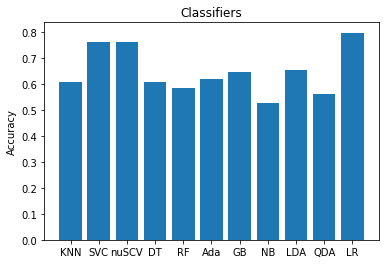

In [45]:
import matplotlib.pyplot as plt
classifier=['KNN','SVC','nuSCV','DT','RF','Ada','GB','NB','LDA','QDA','LR']
y_pos = np.arange(len(classifier))
plt.bar(y_pos,np.array(accuracy))
plt.xticks(y_pos, classifier)
plt.ylabel('Accuracy')
plt.title('Classifiers')

# Principle Component Analysis

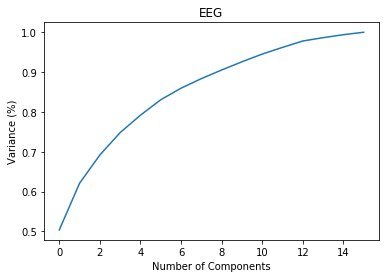

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score

#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_train)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('EEG')
plt.show()

In [0]:
clf = SVC(kernel='rbf')
pca = PCA(n_components=10)

#pipeline = Pipeline([('selector',pca), ('estimator', clf)])
pipeline = Pipeline([('transformer', sc),('selector',pca), ('estimator', clf)])


In [48]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_pca=[]
std_pca=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_pca.append(np.array(scores).mean())
    std_pca.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 58.4559%
SVC
****Results****
Accuracy: 70.3676%
NuSVC
****Results****
Accuracy: 69.1912%
DecisionTreeClassifier
****Results****
Accuracy: 68.0882%
RandomForestClassifier
****Results****
Accuracy: 73.8971%
AdaBoostClassifier
****Results****
Accuracy: 68.0882%
GradientBoostingClassifier
****Results****
Accuracy: 71.6912%
GaussianNB
****Results****
Accuracy: 71.6912%
LinearDiscriminantAnalysis
****Results****
Accuracy: 76.3235%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 70.5147%
LogisticRegression
****Results****
Accuracy: 76.3235%


In [49]:
from sklearn.model_selection import GridSearchCV

clf = SVC(kernel="rbf")
n_components = [5,10,15,20]
Cs = [0.001,0.1, 1,2,3,5,7,10,15,30]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scalar',sc),('selector', pca), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(selector__n_components=n_components,
                              classifier__C=Cs,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.7514705882352941


{'classifier__C': 10, 'classifier__gamma': 0.001, 'selector__n_components': 20}

In [50]:
from sklearn.model_selection import GridSearchCV

clf = KNeighborsClassifier()
n_components = [5,10,15,20]
n_neighbors  = [ 3,4,5,6,7,8,9]
weights  = ['uniform','distance']
metric=['minkowski','manhattan','euclidean']
pipe = Pipeline(steps=[('scalar',sc),('selector', pca), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(selector__n_components=n_components,
                              classifier__n_neighbors=n_neighbors,classifier__weights=weights,classifier__metric=metric),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.6808823529411765


{'classifier__metric': 'manhattan',
 'classifier__n_neighbors': 8,
 'classifier__weights': 'distance',
 'selector__n_components': 10}

In [51]:
clf = LogisticRegression()
n_components = [5,10,15,20]
C = [ 1,2,3,5,7,10,15,30,50,70,100]
penalty=["l1","l2"]
pipe = Pipeline(steps=[('scalar',sc),('selector', pca), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(selector__n_components=n_components,
                             classifier__C=C,classifier__penalty=penalty),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.7985294117647059


{'classifier__C': 1, 'classifier__penalty': 'l1', 'selector__n_components': 15}

# RFE

In [0]:
from sklearn.feature_selection import RFE

In [0]:

clf = SVC(kernel='rbf')
rfe=RFE(SVC(kernel='linear'),n_features_to_select=5,step=1,verbose=0)   

#pipeline = Pipeline([('selector',rfe), ('estimator', clf)])
pipeline = Pipeline([('transformer', sc),('selector',rfe), ('estimator', clf)])


In [54]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_rfe=[]
std_rfe=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_rfe.append(np.array(scores).mean())
    std_rfe.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 63.2353%
SVC
****Results****
Accuracy: 54.7794%
NuSVC
****Results****
Accuracy: 65.7353%
DecisionTreeClassifier
****Results****
Accuracy: 64.2647%
RandomForestClassifier
****Results****
Accuracy: 64.4118%
AdaBoostClassifier
****Results****
Accuracy: 54.7794%
GradientBoostingClassifier
****Results****
Accuracy: 64.4853%
GaussianNB
****Results****
Accuracy: 58.8235%
LinearDiscriminantAnalysis
****Results****
Accuracy: 66.9118%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 68.0882%
LogisticRegression
****Results****
Accuracy: 64.5588%


In [55]:
from sklearn.model_selection import GridSearchCV

clf = SVC(kernel="rbf")
n_features_to_select = [10,15,20,25,30]
step=[5,10]
Cs = [ 1,2,3,5,7,10,15,30]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scalar',sc),('selector', rfe), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(selector__n_features_to_select=n_features_to_select,selector__step=step,
                              classifier__C=Cs,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.7985294117647059


{'classifier__C': 2,
 'classifier__gamma': 0.01,
 'selector__n_features_to_select': 30,
 'selector__step': 5}

# SKbest

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


In [0]:

clf = SVC(kernel='rbf')
skbest=SelectKBest(f_classif, k=10)
#pipeline = Pipeline([('selector',skbest), ('estimator', clf)])
pipeline = Pipeline([('transformer', sc),('selector',rfe), ('estimator', clf)])


In [58]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_kbest=[]
std_kbest=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_kbest.append(np.array(scores).mean())
    std_kbest.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 63.2353%
SVC
****Results****
Accuracy: 54.7794%
NuSVC
****Results****
Accuracy: 65.7353%
DecisionTreeClassifier
****Results****
Accuracy: 61.9118%
RandomForestClassifier
****Results****
Accuracy: 59.7059%
AdaBoostClassifier
****Results****
Accuracy: 54.7794%
GradientBoostingClassifier
****Results****
Accuracy: 64.4853%
GaussianNB
****Results****
Accuracy: 58.8235%
LinearDiscriminantAnalysis
****Results****
Accuracy: 66.9118%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 68.0882%
LogisticRegression
****Results****
Accuracy: 64.5588%


# VarianceThreshold

In [0]:
from sklearn.feature_selection import VarianceThreshold
clf = SVC(kernel='rbf')
selector = VarianceThreshold(0.05)
#pipeline = Pipeline([('selector',algo), ('estimator', clf)])
pipeline = Pipeline([('transformer', sc),('selector',selector), ('estimator', clf)])


In [60]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_var=[]
std_var=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_var.append(np.array(scores).mean())
    std_var.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 60.7353%
SVC
****Results****
Accuracy: 76.3235%
NuSVC
****Results****
Accuracy: 76.3235%
DecisionTreeClassifier
****Results****
Accuracy: 59.8529%
RandomForestClassifier
****Results****
Accuracy: 58.4559%
AdaBoostClassifier
****Results****
Accuracy: 66.9118%
GradientBoostingClassifier
****Results****
Accuracy: 68.0882%
GaussianNB
****Results****
Accuracy: 52.7941%
LinearDiscriminantAnalysis
****Results****
Accuracy: 65.6618%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 56.0294%
LogisticRegression
****Results****
Accuracy: 79.8529%


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/d

# Result

In [61]:
len(accuracy),len(accuracy_pca),len(accuracy_rfe),len(accuracy_kbest),len(accuracy_var)

(11, 11, 11, 11, 11)

In [0]:
result=pd.DataFrame([accuracy,accuracy_pca,accuracy_rfe,accuracy_kbest,accuracy_var],
                    index=['Accuracy','PCA',"RFE",'kbest','VAR'],
                    columns=['KNN','SVC','nuSCV','DT','RF','Ada','GB','NB','LDA','QDA','LR'])

In [0]:
result=result.T

In [64]:

def _color_red_or_green(val):
    color = 'red' if val < 0.7 else 'green'
    return 'color: %s' % color
result.style.applymap(_color_red_or_green)

,Accuracy,PCA,RFE,kbest,VAR
KNN,0.607353,0.584559,0.632353,0.632353,0.607353
SVC,0.763235,0.703676,0.547794,0.547794,0.763235
nuSCV,0.763235,0.691912,0.657353,0.657353,0.763235
DT,0.608824,0.680882,0.642647,0.619118,0.598529
RF,0.585294,0.738971,0.644118,0.597059,0.584559
Ada,0.621324,0.680882,0.547794,0.547794,0.669118
GB,0.645588,0.716912,0.644853,0.644853,0.680882
NB,0.527941,0.716912,0.588235,0.588235,0.527941
LDA,0.656618,0.763235,0.669118,0.669118,0.656618
QDA,0.560294,0.705147,0.680882,0.680882,0.560294
